<a id = "table-of-contents"></a>
# Table of Contents
- [Import data](#import)
- [EDA](#eda)
- [Modelling](#modelling)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# for CNN from scratch
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# for pre-trained CNN
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from keras.callbacks import EarlyStopping

<a id = "import"></a>
# <b><span style='color:#4797ef'>|</span> Import Data</b>

In [4]:
df = pd.read_csv('../data/train.csv', dtype = {'Id': str})
df.head()

,Id,label
0,0560,glass
1,4675,cup
2,0875,glass
3,4436,spoon
4,8265,plate


<a id = "eda"></a>
# <b><span style='color:#4797ef'>|</span> EDA</b>

In [5]:
label_group = df.groupby('label').size().to_frame(name="count")

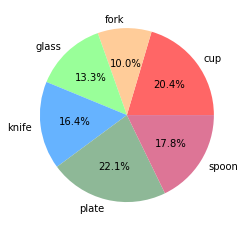

In [6]:
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff', '#8EB897', '#DD7596']

plt.pie(label_group["count"], labels=label_group.index, colors=colors, autopct='%.1f%%')
plt.show() 

The dataset contains 6 classes: plate(22.1%), knife(16.4%), glass(13.3%), fork(10%), cup(20.4%), spoon(17.8%) 

## First look at the images

In [7]:
df["filename"] = '../data/images/' + df['Id'] + '.jpg'

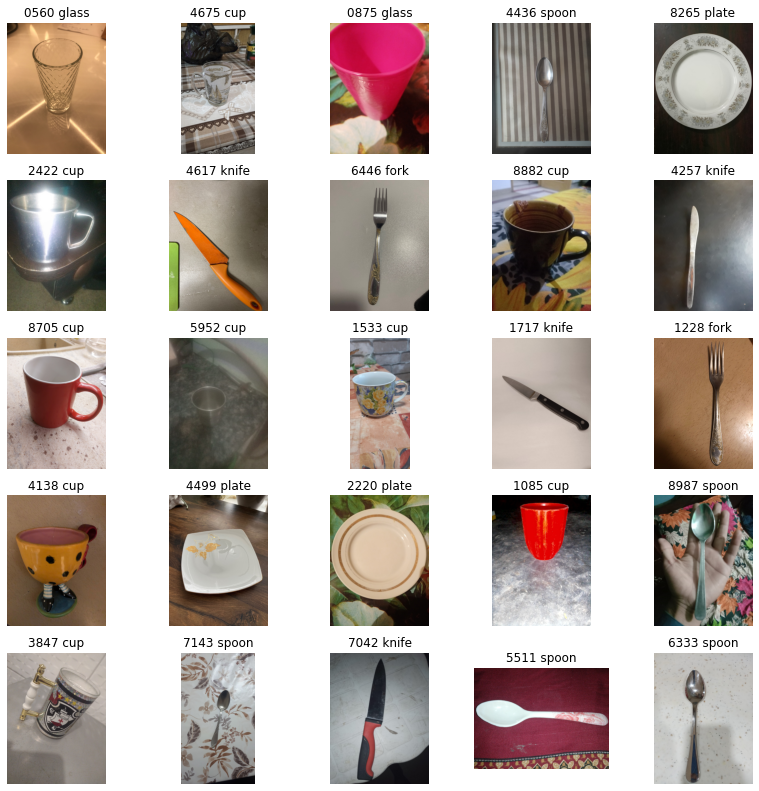

In [8]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(14,14))
 
for i, row in df[0:25].iterrows():
    img = load_img(row["filename"])
    label = row["label"]
    Id = row["Id"]
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(Id + " " + label)
    plt.axis("off")

After examining the data, it was found that the image quality (sharpness/resolution) in some of the photos is poor, the subject is not fully displayed in the photo. Most of the subjects are shown empty, but some, such as plates, are shown filled with food. 

Because of the size of the dataset, we will not manually review and exclude such cases. These cases will make our model more ready for unexpected images.

Objects are shown from various angles that's why we'll use data augmentation.

<a id = "modelling"></a>
# <b><span style='color:#4797ef'>|</span> Modelling</b>

In [9]:
threshold = int(len(df) * 0.8)

df_train = df[:threshold]
df_val = df[threshold:]

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3),
                        activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8), 
              metrics=['acc'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 11,216,198
Trainable params: 11,216,198
Non-trainable params: 0
____________________________________________

In [12]:
def compare_histories(history):
    acc = history.history['acc']
    test_acc = history.history['val_acc']
    loss = history.history['loss']
    test_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axis = plt.subplots(1, 2, figsize=(24,8))

    axis[0].plot(epochs, acc, label='Training acc')
    axis[0].plot(epochs, test_acc, label='Test acc')
    axis[0].set_title('Training and Test Accuracy')
    axis[0].legend()

    axis[1].plot(epochs, loss, label='Training loss')
    axis[1].plot(epochs, test_loss, label='Test loss')
    axis[1].set_title('Training and Test Loss')
    axis[1].legend()

## CNN from scratch

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, # don't forget this...
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 4447 validated image filenames belonging to 6 classes.


In [14]:
train_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [15]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(df_val,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='categorical',
                                                shuffle=True)

Found 1112 validated image filenames belonging to 6 classes.


In [16]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator)

Epoch 1/10
223/223 [==============================] - 164s 732ms/step - loss: 1.7634 - acc: 0.2201 - val_loss: 1.7362 - val_acc: 0.2122
Epoch 2/10
223/223 [==============================] - 155s 696ms/step - loss: 1.7209 - acc: 0.2494 - val_loss: 1.6778 - val_acc: 0.2851
Epoch 3/10
223/223 [==============================] - 201s 902ms/step - loss: 1.7033 - acc: 0.2779 - val_loss: 1.6598 - val_acc: 0.2851
Epoch 4/10
223/223 [==============================] - 196s 880ms/step - loss: 1.6858 - acc: 0.2840 - val_loss: 1.6552 - val_acc: 0.2905
Epoch 5/10
223/223 [==============================] - 237s 1s/step - loss: 1.6747 - acc: 0.3056 - val_loss: 1.6457 - val_acc: 0.3040
Epoch 6/10
223/223 [==============================] - 243s 1s/step - loss: 1.6673 - acc: 0.3054 - val_loss: 1.6351 - val_acc: 0.3085
Epoch 7/10
223/223 [==============================] - 239s 1s/step - loss: 1.6594 - acc: 0.3096 - val_loss: 1.6031 - val_acc: 0.3408
Epoch 8/10
223/223 [==============================] - 199

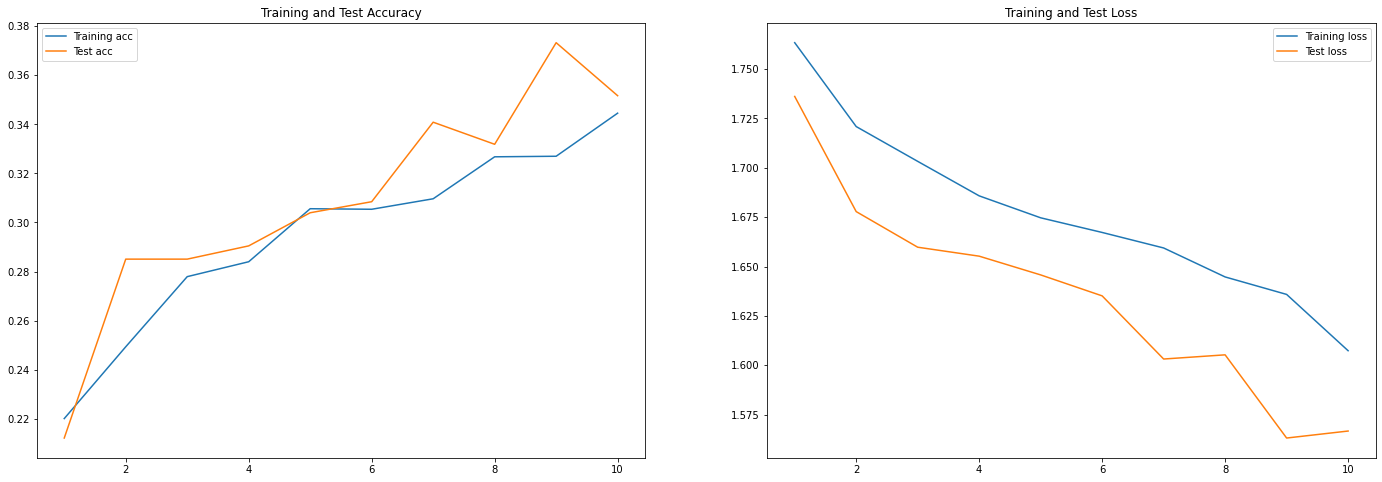

In [17]:
compare_histories(history=history)

In [18]:
model.save("../models/CNN_aug")

INFO:tensorflow:Assets written to: ../models/CNN_aug\assets


## Pre-trained CNN - Xception + tune parameter

In [19]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [20]:
# train_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train_Xc_generator = train_xc_datagen.flow_from_dataframe(
#     df_train,
#     x_col='filename',
#     y_col='label',
#     target_size=(299, 299),
#     batch_size=32
# )

train_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_Xc_generator = train_Xc_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32)

Found 4447 validated image filenames belonging to 6 classes.


In [22]:
val_Xc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_Xc_generator = val_Xc_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32
)

Found 1112 validated image filenames belonging to 6 classes.


In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr) 
    history = model.fit(train_Xc_generator, epochs=10,
                        validation_data=val_Xc_generator)
#     es = EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.970)

#     history = model.fit(train_xc_generator,
#                         epochs=10,
#                         validation_data=val_xc_generator,
#                         callbacks=[es])
scores[lr] = history.history

print()
print()

0.0001
Epoch 1/10
139/139 [==============================] - 1714s 12s/step - loss: 1.3680 - accuracy: 0.6375 - val_loss: 0.9889 - val_accuracy: 0.8390
Epoch 2/10
139/139 [==============================] - 1632s 12s/step - loss: 0.8447 - accuracy: 0.8702 - val_loss: 0.6263 - val_accuracy: 0.9146
Epoch 3/10
139/139 [==============================] - 1171s 8s/step - loss: 0.6057 - accuracy: 0.8959 - val_loss: 0.4575 - val_accuracy: 0.9290
Epoch 4/10
139/139 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.9044 

<a id = "submission"></a>
# <b><span style='color:#4797ef'>|</span> Submission</b>